In [1]:
yari = "loser"

In [2]:
import os
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import time
import random 

from sklearn.metrics import f1_score

In [3]:
if torch.backends.mps.is_built():
    device = torch.device("mps")
    print("M1 pro GPU is activated")
else:
    device = torch.device("cuda")
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device:{torch.cuda.current_device()}")
        
    print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
torch.cuda.is_available()

True

We will import the images already resized 250 x 250

In [5]:
x = torch.load("images_data.pt")


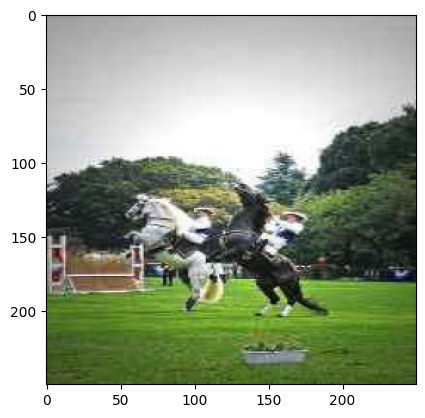

In [6]:
plt.imshow(x[1].permute(1, 2, 0))
plt.show()

In [7]:
with open('train.csv') as fp:
    # read a list of lines into data
    data = fp.readlines()

data[4790] = data[4790].replace("/", "")
data[14716] = data[14716].replace("/", "")
data[14961] = data[14961].replace("/", "")
data[29895] = data[29895].replace("/", "")

# and write everything back
with open('train.csv', 'w') as file:
    file.writelines(data)

In [8]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [9]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [10]:
# for i in range(df_train.shape[0]):
#     df_train.Labels[i] = [int(j) for j in df_train.Labels[i].split()]
# max_i = 0
# for i in df_train.Labels:
#     max_i = max(max_i, max(i))
# min_i = 19
# for i in df_train.Labels:
#     min_i = min(min_i, min(i))
# min_i

# for i in range(1, max_i+1):
#     df_train[f'{i}'] = 0
# for i in range(df_train.shape[0]):
#     for j in df_train.Labels[i]:
#         df_train[f"{j}"][i] = 1
# df_train.to_csv("df_train.csv", index=False)

In [11]:
df_train.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [12]:
for i in range(df_train.shape[0]):
    if f"{i}.jpg" != df_train.loc[i,'ImageID']:
        print(i)

In [13]:
df_train = pd.read_csv("df_train.csv")

In [14]:
df_train.head()

,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_train = df_train.drop(['12'], axis=1)
df_train.head()

,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,9,10,11,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_string(input_string):
    # Tokenize the input string using NLTK's word_tokenize function
    tokens = nltk.word_tokenize(input_string)
    
    # Convert all tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    
    # Remove stop words (common words that don't add much meaning)
    stop_words = set(stopwords.words('english'))
    #tokens = [token for token in tokens if not token in stop_words]
    tokens = [token for token in tokens if token and not token in stop_words]
    
    # Stem the tokens (reduce each token to its root form)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# tkn = preprocess_string("Yari, the man, was once seen sitting on the couch and sipping too few boba teas")
# tkn

In [18]:
embedding_size = 20
vob_size = 63

def word_embedding(input_seq, vob_size, dtype=torch.float):
    word_embed = nn.Embedding(vob_size, embedding_size)
    embeddings = word_embed(input_seq.long())
    return embeddings

In [19]:
from torch.utils.data import Dataset

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class TrainDataset(Dataset):
    def __init__(self, images, csv, train, test,full=False):
        self.csv = csv # df_train
        self.train = train # boolean
        self.full = full
        self.test = test # boolean
        self.images = images

        self.all_image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']

        #self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))

        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.full == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))
            
            self.image_names = list(self.all_image_names)
            self.labels = list(self.all_labels)
            print(f"Number of training images: {self.all_labels.shape[0]}")
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                # transforms.ColorJitter(),
                transforms.Normalize(mean, std)

            ])
        elif self.train == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                # transforms.ColorJitter(),
                transforms.Normalize(mean, std)
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels','Caption'], axis=1))
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.Normalize(mean, std)
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[:])
             # define the test transforms
            print(f"Number of test images: {len(self.image_names)}")
            self.transform = transforms.Compose([
                transforms.Normalize(mean, std)
            ])
            
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = self.transform(image)
        caption = self.captions[index]
        if self.train == True:   #training
            targets = self.labels[index]
            return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'name' : self.image_names[index],
            'caption' : caption,
        }
        elif self.train == False and self.test == False:  #validation
             targets = self.labels[index]
             return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'caption' : caption,
            'name' : self.image_names[index],
        }
        elif self.test == True and self.train == False:   #testing
            return {
            'image': torch.tensor(image, dtype=torch.float32),
            'name' : self.all_image_names[index],
            'caption' : caption,
        }
       
        
        

In [20]:
class TestDataset(Dataset):
    def __init__(self, images, csv):
        self.csv = csv
        self.images = images

        self.all_image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']
        print(f"Number of test images: {len(self.csv)}")
        self.transform = transforms.Compose([
            transforms.Normalize(mean, std)
        ])
            
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = self.transform(image)
        caption = self.captions[index]
        return {
        'image': torch.tensor(image, dtype=torch.float32),
        'name' : self.all_image_names[index],
        'caption' : caption,
        }
       

In [21]:
batch_size = 32
train_data = TrainDataset(
    x[:30000], df_train, train=True, test=False
)
# validation dataset
valid_data = TrainDataset(
    x[:30000], df_train, train=False, test=False
)

full_data = TrainDataset(
    x[:30000],csv = df_train, test = False, train = True, full=True
)

test_data = TestDataset(
    x[-10000:],csv = df_test
)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

full_loader = DataLoader(
    full_data,
    batch_size=batch_size,
    shuffle=True
)

Number of training images: 25500
Number of validation images: 4500
Number of training images: 30000
Number of test images: 10000


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


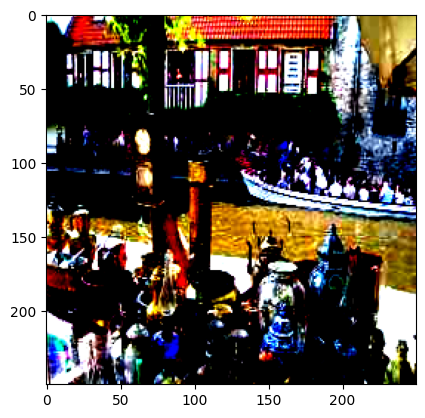

In [22]:
plt.imshow(valid_data[len(valid_data) - 1]['image'].permute(1, 2, 0))
plt.show()

In [23]:
valid_data[len(valid_data) - 1]['caption']

C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


'There are a coupe of dozen vases left out.'

# Distribution of Labels

In [24]:
# label_df = df_train.explode("Labels")
# label_counts = label_df['Labels'].value_counts()
# sorted_label_counts = label_counts.sort_index()
# #sorted_label_counts.plot.bar()
# plt.bar(sorted_label_counts.index, sorted_label_counts.values)
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.title("Label Distribution")
# plt.yticks(np.arange(0, 24000, step=1000))
# plt.xticks(sorted_label_counts.index, sorted_label_counts.index)
# plt.grid()
# plt.show()


In [25]:
# sorted_label_counts

# Networks


In [26]:
from torchvision import models
#Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class Resnext50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True).to(device=device)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

In [27]:
best_cv_model = Resnext50(num_classes=18)
best_cv_model = best_cv_model.to(device)
best_cv_model.train()

c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [28]:
lr = 1e-4
# num_epochs = 25
optimizer = torch.optim.Adam(best_cv_model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [29]:
# outputs = best_cv_model(train_data[0:32]['image'].to(device))
# outputs = outputs.detach().cpu().numpy()
# argmax_indices = np.argmax(outputs, axis=1)
# outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
# predicted = np.round(outputs)
# f1_score(predicted, train_data[0:32]['label'].numpy(), average = 'samples')

In [30]:
num_epochs = 3
# train_losses = torch.zeros(num_epochs)
# val_losses = torch.zeros(num_epochs)
# f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(full_loader):
        # if i % 10 == 0:
        #     print(best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion, device))
        images = data['image'].to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_cv_model(images)
        loss = criterion(outputs, target)
        train_loss += loss.item()
        # print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        # print(i/len(train_loader)*100)

    print(it)
    train_losses[it] = train_loss/len(full_loader)
    # result = best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    # val_losses[it] = result['loss']
    # f1_scores[it] = result['f1_score']
    

C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


KeyboardInterrupt: 

In [ ]:
checkpoint_path = 'ResNet7.pth'
checkpoint = {'model': best_cv_model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [ ]:
submission = predict_test_data_vision(best_cv_model, test_loader=test_loader, device=device, batch_size = batch_size)
submission

C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,1 3 8
9997,39997.jpg,1
9998,39998.jpg,1


In [ ]:
submission.to_csv('predictions.csv',index=False)

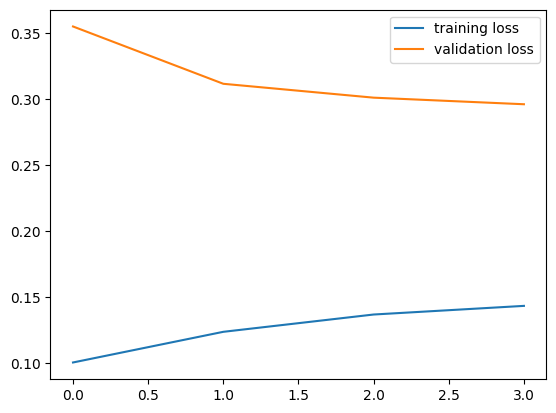

In [ ]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [ ]:
f1_scores

tensor([0.4685, 0.4862, 0.5028, 0.5026, 0.5006, 0.4276, 0.4076, 0.4455, 0.4726,
        0.4463, 0.4764, 0.4594, 0.4544, 0.4877, 0.4804, 0.4695, 0.4864, 0.4407,
        0.4319, 0.4814, 0.4754, 0.4386, 0.5031, 0.5261, 0.4747])

In [ ]:
def predict_test_data_vision(model, test_loader, device, batch_size):
    model.eval()
    model = model.to(device)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            #images
            images = data['image'].to(device)
            pred = model(images)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1
            # print(indices)
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

In [ ]:
best_cv_model = AlexNet(19).to(device)
checkpoint = torch.load("AlexNet2.pth")
# Load the model state dictionary from the checkpoint
best_cv_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
submission = predict_test_data_vision(best_cv_model, test_loader=test_loader, device=device, batch_size = batch_size)
submission

C:\Users\david\AppData\Local\Temp\ipykernel_26984\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,1
9997,39997.jpg,1
9998,39998.jpg,1


In [ ]:
submission.to_csv('predictions.csv',index=False)

# our nlp

In [32]:
df_train = df_train.drop(columns = 'Caption').join(df_train['Caption'].str.replace('\"', ''))
df_test = df_test.drop(columns = 'Caption').join(df_test['Caption'].str.replace('\"', ''))
whole_sentences = pd.concat([df_train['Caption'], df_test['Caption']], axis=0, ignore_index=True)
whole_sentences

0         Woman in swim suit holding parasol on sunny day.
1        A couple of men riding horses on top of a gree...
2        They are brave for riding in the jungle on tho...
3        a black and silver clock tower at an intersect...
4         A train coming to a stop on the tracks out side.
                               ...                        
39995    A group of men riding surfboards riding a mass...
39996    A motorcycle parked next to a car in a parking...
39997              a little boy that is playing with a wii
39998    group of kids play Frisbee golf in the middle ...
39999     A man in a gray jacket standing next to a woman.
Name: Caption, Length: 40000, dtype: object

In [33]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords as sw
# stop_words = sw.words()
STOPWORDS = set(sw.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
def sent_split(input_string): # string to pure word
    splits = []
    for sent in input_string:
        # print(text)
        sent = sent.lower() # lowercase
        sent = re.sub(r'[^A-Za-z]+', ' ', sent) # remove symbols / digits
        # text = re.sub(r'[0-9]','',text)
        orig_sent = []
        for item in sent.split():
            if item not in STOPWORDS: # remove stopword
                orig_sent.append(item)

        lem = [lemmatizer.lemmatize(sent) for sent in orig_sent] # lammatisation

        # token = [word_tokenize(word) for word in text_le]
        splits.append(lem)
    return splits

In [35]:
max_seq_len = max(len(s) for s in sent_split(whole_sentences))
max_seq_len

28

In [36]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
word_embedding_model = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [37]:
splitted_sentences = sent_split(whole_sentences)
word_list = []
for sent in splitted_sentences:
    for word in sent:
        word_list.append(word)
len(word_list)

233353

In [38]:
vocab_list = []
for sent in splitted_sentences:
    for word in sent:
        vocab_list.append(word)

In [39]:
# Create the Embedding lookup table
import numpy as np
emb_dim = word_embedding_model.vector_size
word_set = set()
min_freq = 5
from collections import Counter
c = Counter(vocab_list)
for i in c:
    if c[i] >= min_freq:
        word_set.add(i)
word_set.add('[PAD]')
word_set.add('[UNKOWN]')
word_list=list(word_set)
word_list.sort()
emb_table = []
word_index = {}
emb_table = []
for i, word in enumerate(word_list):
    word_index[word] = i
    if word in word_embedding_model:
        emb_table.append(word_embedding_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)
    
print(emb_table)
emb_table.shape

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.17480469  0.17871094  0.09082031 ...  0.07568359 -0.11181641
  -0.0625    ]
 ...
 [-0.08544922 -0.10253906 -0.48632812 ...  0.02075195  0.08496094
   0.00061035]
 [-0.07421875 -0.10205078  0.20117188 ... -0.25390625  0.06054688
  -0.21289062]
 [-0.04248047  0.16015625 -0.2265625  ...  0.18945312 -0.00692749
   0.1328125 ]]


(2218, 300)

In [40]:
class Tokenizer:
    def __init__(self):
        pass
    def tokenize(self, sentences, seq_len, word_index):
        sentences = sent_split(sentences)
        sent_encoded = []
        for sent in sentences:
            temp_encoded = [word_index[word] if word in word_index else word_index['[UNKOWN]'] for word in sent]
            if len(temp_encoded) < seq_len:
                temp_encoded += [word_index['[PAD]']] * (seq_len - len(temp_encoded))
            else:
                temp_encoded = temp_encoded[:seq_len]
            sent_encoded.append(temp_encoded)
        return sent_encoded

In [41]:
vocab_size = emb_table.shape[0]
emb_dim = emb_table.shape[1]
vocab_size, emb_dim

(2218, 300)

# BiLSTM

In [42]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

n_hidden = 300

lr = 1e-4

seq_len = max_seq_len

class Bi_LSTM_Emb(nn.Module):
    def __init__(self,n_classes):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

    def calculate_f1_score_and_loss(self, loader, criterion, device):
            self.eval()
            val_loss = 0
            with torch.no_grad():
                y_pred = []
                y_true = []
                for data in loader:
                    captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
                    captions = torch.from_numpy(np.array(captions)).to(device)
                    target = data['label'].to(device)
                    outputs = self(captions)
                    loss = criterion(outputs, target)
                    val_loss += loss.item()
                    outputs = outputs.cpu().numpy()
                    argmax_indices = np.argmax(outputs, axis=1)
                    outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                    predicted = np.round(outputs)
                    y_pred.extend(predicted)
                    y_true.extend(target.cpu().numpy())
                y_pred = np.array(y_pred)
                y_true = np.array(y_true)
                res = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
            return {'f1_score' : res, 'loss' : val_loss/len(loader)}

In [43]:
best_nlp_model = Bi_LSTM_Emb(18)
best_nlp_model = best_nlp_model.to(device)
best_nlp_model.train()

Bi_LSTM_Emb(
  (emb): Embedding(2218, 300)
  (lstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=600, out_features=18, bias=True)
  (sigm): Sigmoid()
)

In [45]:
tokenizer = Tokenizer()
optimizer = torch.optim.Adam(best_nlp_model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.BCELoss()

In [46]:
num_epochs = 18
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
save_freq = 3
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        best_nlp_model.train()
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_nlp_model(captions)
        loss = criterion(outputs, target)
        train_loss+=loss.item()
        if i % 100 == 0:
            print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        # print(i)
        # if i % 100 == 0:
        #     print(best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion,device))
            
    print(it)
    if it % save_freq == 0 and it != 0:
        checkpoint_path = f'new_BiLSTM{it}.pth'
        checkpoint = {'model': best_nlp_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': num_epochs}
        torch.save(checkpoint, checkpoint_path)
    train_losses[it] = train_loss/len(train_loader)
    result = best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    val_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']
    

C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.690665066242218
0.2487858682870865
0.24461455643177032
0.19749517738819122
0.18281155824661255
0.1565452218055725
0.16552843153476715
0.14011618494987488
0


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.12838433682918549
0.17336885631084442
0.14262685179710388
0.1536441147327423
0.14876192808151245
0.11338017880916595
0.12633346021175385
0.10295183211565018
1


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.12352018803358078
0.13394184410572052
0.11306414753198624
0.1159992516040802
0.1743675023317337
0.10120389610528946
0.08044882863759995
0.14822302758693695
2


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.06056157872080803
0.11110462993383408
0.12974034249782562
0.09343443810939789
0.12243971973657608
0.08340178430080414
0.0705040991306305
0.1399514228105545
3


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.10982654243707657
0.08570791780948639
0.17425020039081573
0.09594670683145523
0.10591205209493637
0.12067309767007828
0.09453418105840683
0.09123363345861435
4


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.08264531940221786
0.07904089987277985
0.0892486572265625
0.07987601310014725
0.08537647873163223
0.13428905606269836
0.10034055262804031
0.12253425270318985
5


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.0812726691365242
0.14637036621570587
0.0857049897313118
0.07899174839258194
0.09529013186693192
0.06123955920338631
0.08992349356412888
0.10191086679697037
6


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.06495561450719833
0.08297506719827652
0.11165612190961838
0.15964213013648987
0.09414809942245483
0.1072402372956276
0.09238648414611816
0.09343332052230835
7


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.11416024714708328
0.07698323577642441
0.06943121552467346
0.05770013853907585
0.08955778926610947
0.109491266310215
0.07968168705701828
0.08647482842206955
8


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.09661626815795898
0.06654763966798782
0.09163559228181839
0.08344432711601257
0.10884866863489151
0.0796561911702156
0.08571837097406387
0.06856731325387955
9


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.08310874551534653
0.10255412012338638
0.12003254890441895
0.14868129789829254
0.09513814747333527
0.14925019443035126
0.09897894412279129
0.06688409298658371
10


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.10112100094556808
0.09602760523557663
0.07745411247015
0.06872198730707169
0.11979929357767105
0.08962506800889969
0.09212636202573776
0.08428458124399185
11


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.10725100338459015
0.06985277682542801
0.09646960347890854
0.0894647166132927
0.08319122344255447
0.0759378969669342
0.13086636364459991
0.12180932611227036
12


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.10389423370361328
0.12971968948841095
0.09121378511190414
0.0933067575097084
0.10040793567895889
0.08642008900642395
0.07316979020833969
0.10604063421487808
13


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.05255371332168579
0.0992889255285263
0.10208737850189209
0.0696074441075325
0.13279269635677338
0.10998032987117767
0.10627775639295578
0.05641411989927292
14


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.06705676019191742
0.07836079597473145
0.10129792243242264
0.08665750175714493
0.08535141497850418
0.11301577091217041
0.07008480280637741
0.07829059660434723
15


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.09498511254787445
0.07781336456537247
0.08016249537467957
0.059227362275123596
0.09031059592962265
0.11230672895908356
0.07768271118402481
0.09851719439029694
16


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.09867402911186218
0.07924053817987442
0.1130504384636879
0.10629395395517349
0.0760309025645256
0.08724063634872437
0.06962387263774872
0.07468990236520767
17


C:\Users\david\AppData\Local\Temp\ipykernel_1844\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


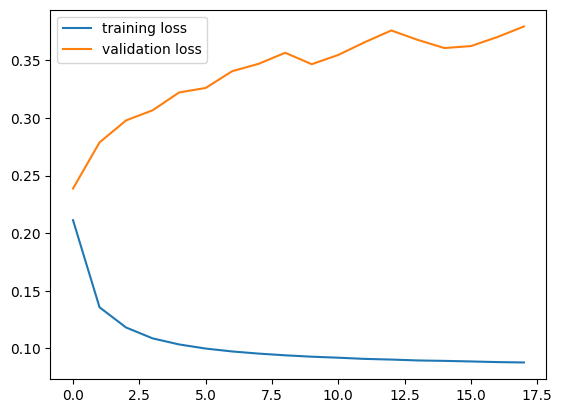

In [47]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [82]:
checkpoint_path = 'BiLSTM3.pth'
checkpoint = {'model': best_nlp_model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [119]:
best_nlp_model = Bi_LSTM_Emb(19)
checkpoint = torch.load("BiLSTM2.pth")
# Load the model state dictionary from the checkpoint
best_nlp_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [65]:
def predict_test_data_caption(model, test_loader, device, batch_size):
    model.eval()
    model = model.to(device)
    y_pred = torch.zeros(len(test_data), 18)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)
            pred = model(captions).to(device)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            # indices[indices[:, 1] > 10, 1] += 1
            # print(indices)
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

In [127]:
submission = predict_test_data_caption(best_nlp_model, test_loader, device, batch_size)
print(submission.head())
submission.to_csv('predictions.csv', index = False)

C:\Users\david\AppData\Local\Temp\ipykernel_26984\782737087.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\782737087.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\782737087.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_26984\78

     ImageID Labels
0  30000.jpg      1
1  30001.jpg      1
2  30002.jpg      1
3  30003.jpg      1
4  30004.jpg      1


# AlexNet

In [33]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5, num_filters = 1) -> None:
        super().__init__()
        self.features = nn.Sequential(
        nn.Conv2d(3, int(64*num_filters), kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(int(64*num_filters), int(192*num_filters), kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(int(192*num_filters), int(384*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(int(384*num_filters), int(256*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(int(256*num_filters), int(256*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )


        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))


        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(int(256*num_filters) * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self.sigm = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.sigm(x)
        return x

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

In [34]:
best_cv_model = AlexNet(num_classes=18)
best_cv_model = best_cv_model.to(device)
best_cv_model.train()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [35]:
optimizer = torch.optim.Adam(best_cv_model.parameters(), lr=lr)
criterion = nn.BCELoss()

NameError: name 'lr' is not defined

In [36]:
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        images = data['image'].to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_cv_model(images)
        loss = criterion(outputs, target)
        train_loss += loss.item()
        # print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        if i % 5 == 0:
            print(best_cv_model.calculate_f1_score(valid_loader, device))
    print(it)
    train_losses[it] = train_loss/len(full_loader)
    result = best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    val_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']
    

NameError: name 'num_epochs' is not defined

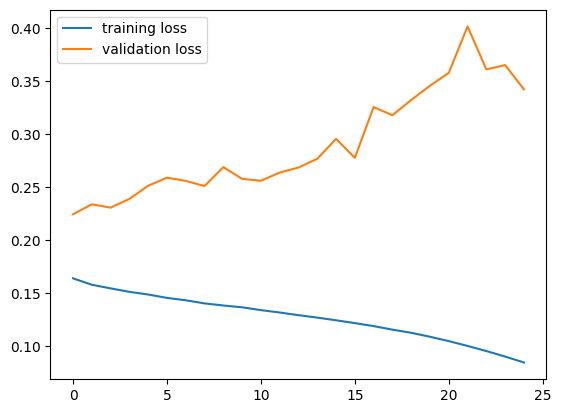

In [117]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [139]:
f1_scores

tensor([0.6314, 0.6314, 0.6314, 0.6314, 0.6314, 0.5497, 0.6223, 0.6296, 0.6309,
        0.6300, 0.6190, 0.5787, 0.5570, 0.5499, 0.4834, 0.5925, 0.3052, 0.3766,
        0.2249, 0.3482, 0.4587, 0.3610, 0.3386, 0.4677, 0.4971])

In [137]:
checkpoint_path = 'AlexNet3.pth'
checkpoint = {'model': best_cv_model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [251]:
def calculate_metrics_caption(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return  {
            'f1_score': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [252]:
outputs = model(captions) #could be different from 64 because we are considering only the last trimmed batch
print(len(outputs))
with torch.no_grad():
    result = calculate_metrics_caption(outputs.cpu().numpy(), target.cpu().numpy())
result

32


{'f1_score': 0.40520833333333334}

In [ ]:
x = torch.rand((5,7))
x

tensor([[0.7171, 0.0480, 0.7251, 0.0943, 0.1608, 0.2358, 0.3761],
        [0.5684, 0.0985, 0.9322, 0.4282, 0.5315, 0.9597, 0.0348],
        [0.0113, 0.8012, 0.6290, 0.7249, 0.6215, 0.4123, 0.3687],
        [0.6897, 0.7525, 0.9105, 0.7414, 0.9835, 0.1199, 0.6089],
        [0.5733, 0.3000, 0.3894, 0.5634, 0.3597, 0.9796, 0.1053]])

In [ ]:
_, argmax_indices = torch.max(x, dim=1)
x[torch.arange(x.size(0)), argmax_indices] = 1
x

tensor([[0.7171, 0.0480, 1.0000, 0.0943, 0.1608, 0.2358, 0.3761],
        [0.5684, 0.0985, 0.9322, 0.4282, 0.5315, 1.0000, 0.0348],
        [0.0113, 1.0000, 0.6290, 0.7249, 0.6215, 0.4123, 0.3687],
        [0.6897, 0.7525, 0.9105, 0.7414, 1.0000, 0.1199, 0.6089],
        [0.5733, 0.3000, 0.3894, 0.5634, 0.3597, 1.0000, 0.1053]])

In [193]:
def predict_test_data_caption(model, test_loader, device, batch_size):
    model.eval()
    y_pred = torch.zeros(len(test_data), 18)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            
            captions = torch.from_numpy(np.array(captions)).to(device)
            #captions = data['Caption'].to(device)
            pred = model(captions)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1 ### incrementing labels that are bigger than 10, since we eliminated the 12 label
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            print(indices_by_row)
            break
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results


    return df_pred

In [196]:
my_indices = torch.tensor([[0,0],[1,14]])
my_indices[:, 1] > 10
my_indices[my_indices[:, 1] > 10, 1] += 1
my_indices

tensor([[ 0,  0],
        [ 1, 15]])

In [194]:
pred = predict_test_data_caption(best_nlp_model, test_loader, device,batch_size=batch_size)

(tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'))


C:\Users\david\AppData\Local\Temp\ipykernel_2972\1553103947.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


In [190]:
pred.head(15)

,ImageID,Labels
0,,
1,,
2,,
3,,
4,,
5,,
6,,
7,,
8,,
9,,


In [ ]:
pred.to_csv('predictions.csv',index=False)

# Define a EffNet Model

In [28]:
from efficientnet_pytorch import EfficientNet
best_cv_model = EfficientNet.from_pretrained('efficientnet-b7')

Loaded pretrained weights for efficientnet-b7


In [29]:
class EffNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        EN = EfficientNet.from_pretrained('efficientnet-b7').to(device=device)
        EN._fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features = EN._fc.in_features, out_features = num_classes)
        )
        self.base_model = EN
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [33]:
device = None
best_cv_model = EffNet(18)
best_cv_model = best_cv_model.to(device)
best_cv_model.train()

Loaded pretrained weights for efficientnet-b7


EffNet(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [34]:
lr = 1e-4
num_epochs = 25
optimizer = torch.optim.Adam(best_cv_model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [ ]:
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        images = data['image'].to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_cv_model(images)
        loss = criterion(outputs, target)
        # train_loss += loss.item()
        print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        # if i % 5 == 0:
        #     print(best_cv_model.calculate_f1_score(valid_loader, device))
    print(it)
    # train_losses[it] = train_loss/len(full_loader)
    # result = best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    # val_losses[it] = result['loss']
    # f1_scores[it] = result['f1_score']

In [43]:
device = torch.device("cuda")
import torchvision.models as models
densenet = models.densenet121(pretrained=True).to(device)

c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        densenet = models.densenet121(pretrained=True).to(device)
        densenet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features = densenet.fc.in_features, out_features = num_classes)
        )
        self.base_model = densenet.to(device)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [52]:
best_cv_model = DenseNet(18)
best_cv_model.train()
best_cv_model = best_cv_model.to(device)

AttributeError: 'DenseNet' object has no attribute 'fc'

In [48]:
lr = 1e-4
num_epochs = 25
optimizer = torch.optim.Adam(best_cv_model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [46]:
# train_losses = torch.zeros(num_epochs)
# val_losses = torch.zeros(num_epochs)
# f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        images = data['image'].to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_cv_model(images)
        loss = criterion(outputs, target)
        # train_loss += loss.item()
        print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        # if i % 5 == 0:
        #     print(best_cv_model.calculate_f1_score(valid_loader, device))
    print(it)
    # train_losses[it] = train_loss/len(full_loader)
    # result = best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    # val_losses[it] = result['loss']
    # f1_scores[it] = result['f1_score']

C:\Users\david\AppData\Local\Temp\ipykernel_42812\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Define a LSTM Model

In [67]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

n_hidden = 300

lr = 1e-4

seq_len = max_seq_len

class LSTM(nn.Module):
  def __init__(self, n_class):
    super(LSTM, self).__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.emb.weight.data.copy_(torch.from_numpy(emb_table))
    self.emb.weight.requires_grad = False
    self.lstm = nn.LSTM(emb_dim, n_hidden, num_layers=2, batch_first =True, dropout=0.5)
    self.linear = nn.Linear(n_hidden,n_class)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input):
    input = self.emb(input)
    input,_ = self.lstm(input)
    input = self.linear(input[:,-1,:])
    return self.sigmoid(input)
  
  def calculate_f1_score_and_loss(self, loader, criterion, device):
    self.eval()
    val_loss = 0
    with torch.no_grad():
        y_pred = []
        y_true = []
        for data in loader:
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)
            target = data['label'].to(device)
            outputs = self(captions)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            outputs = outputs.cpu().numpy()
            argmax_indices = np.argmax(outputs, axis=1)
            outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
            predicted = np.round(outputs)
            y_pred.extend(predicted)
            y_true.extend(target.cpu().numpy())
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        res = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    return {'f1_score' : res, 'loss' : val_loss/len(loader)}


In [68]:
best_nlp_model = LSTM(18)
best_nlp_model = best_nlp_model.to(device)
best_nlp_model.train()

LSTM(
  (emb): Embedding(2218, 300)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=300, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)

In [75]:
tokenizer = Tokenizer()
optimizer = torch.optim.Adam(best_nlp_model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.BCELoss()

In [76]:
num_epochs = 3
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        best_nlp_model.train()
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_nlp_model(captions)
        # print(target.size())
        # print(outputs.size())
        loss = criterion(outputs, target)
        train_loss+=loss.item()
        if i % 500 == 0:
            print(loss.item())
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        # print(i)
        # if i % 100 == 0:
        #     print(best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion,device))
            
    print(it)
    train_losses[it] = train_loss/len(train_loader)
    result = best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    val_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']

C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.12274764478206635
0.07943467050790787
0


C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.15107256174087524
0.13480491936206818
1


C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0.13436612486839294
0.13826516270637512
2


C:\Users\david\AppData\Local\Temp\ipykernel_8304\375505942.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


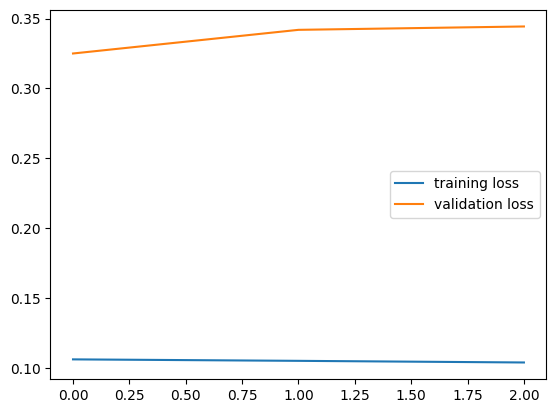

In [77]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [78]:
checkpoint_path = 'LSTM3.pth'
checkpoint = {'model': best_nlp_model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [79]:
submission = predict_test_data_caption(best_nlp_model, test_loader, device, batch_size)
print(submission.head())
submission.to_csv('predictions.csv', index = False)

C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\134

     ImageID Labels
0  30000.jpg      1
1  30001.jpg      1
2  30002.jpg      1
3  30003.jpg      1
4  30004.jpg      1


C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_8304\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


# Define a GRU Model

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, in_feature, hidden_size, n_class):
    super(GRUModel, self).__init__()
    self.in_feature = in_feature
    self.hidden_size = hidden_size
    self.n_class = n_class
    self.fully_connected_1 = nn.Linear(in_feature+self.hidden_size, 2 * self.hidden_size)
    self.fully_connected_2 = nn.Linear(in_feature+self.hidden_size, self.hidden_size)
    self.pred_layer = nn.Linear(self.hidden_size, self.n_class)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input, dtype=torch.float):
    T = input.shape[0]
    batch_size = input.shape[1]
    outputs = torch.zeros(size=(T, batch_size, self.hidden_size), dtype=dtype)
    state = torch.zeros(size=(batch_size, self.hidden_size), dtype=dtype)
    # implement GRU forward procedure here
   
    return outputs, state

  def predict(self, input_state, dtype=torch.float):
    _, last_state = self.forward(input_state)
    predict = self.pred_layer(last_state)
    return predict

# COMBINED MODEL

In order to combine the NLP and classification model we need to concatenate the features and run a third classifier on this concatenated features

Define the third classifier

We need to choose where to put either 19 or 18 labels

In [83]:
n_labels = 18

best_cv_model = Resnext50(num_classes=n_labels)
best_nlp_model = Bi_LSTM_Emb(n_classes=n_labels)
checkpoint = torch.load("ResNet4.pth")
# Load the model state dictionary from the checkpoint
best_cv_model.load_state_dict(checkpoint['model'])

checkpoint = torch.load("BiLSTM3.pth")
# Load the model state dictionary from the checkpoint
best_nlp_model.load_state_dict(checkpoint['model'])
# Define Classifier
classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=3100),
    nn.ReLU(),
    nn.Linear(in_features=3100, out_features=n_labels),
    nn.Sigmoid()
)


# Switch model to GPU.
best_cv_model = best_cv_model.to(device)
best_nlp_model = best_nlp_model.to(device)
classifier = classifier.to(device)

tokenizer = Tokenizer()
     

c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
criterion = nn.BCELoss().to(device=device)
optimizer = optim.Adam(classifier.parameters(), lr=lr)

In [87]:
epochs = 20
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
iter = 0
test_frequency = 100 
saving_freq = 1
for epoch in range(epochs):
    batch_loss_values = []
    train_loss=0
    for el in train_loader:
        best_cv_model.train()
        best_nlp_model.train()

        # images part
        targets = el['label'].to(device)
        images = el['image'].to(device)
        # NLP part
        captions = tokenizer.tokenize(el['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)

        # combining
        optimizer.zero_grad()
        img_out = best_cv_model(images)
        nlp_out = best_nlp_model(captions)
        concatenating_outs = torch.concat((img_out, nlp_out), 1)

        combined_model = classifier(concatenating_outs)
        
        #loss and backward pass
        loss = criterion(combined_model, targets.type(torch.float))
        train_loss += loss.item()
        if i % 100 == 0:
            print(loss.item())
        # bl_value = loss.item()
        # print(bl_value)

        loss.backward()
        

        optimizer.step()
        # optimizer.zero_grad() ### WHY??

    #     # batch_loss_values.append(bl_value)
    #     val_loss = 0
    #     with torch.no_grad():
    #     #     res = calculate_metrics(combined_model.cpu().numpy(), targets.cpu().numpy())
    #     #     print(res['f1_score'])
    #     # if iter % test_frequency == 0:
    #     #     with torch.no_grad():
    #     #         model_res = []
    #     #         targets = []
    #         y_pred = []
    #         y_true = []
    #         for data in valid_loader:
    #             best_cv_model.eval()
    #             best_nlp_model.eval()

    #             # images part
    #             targets = data['label'].to(device)
    #             images = data['image'].to(device)

    #             # NLP part
    #             captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
    #             captions = torch.from_numpy(np.array(captions)).to(device)

    #             # combining
    #             img_out = best_cv_model(images)
    #             nlp_out = best_nlp_model(captions)

    #             combined_outs = classifier(torch.concat((img_out, nlp_out), 1))
    #             loss_combined = criterion(combined_outs,targets)
    #             val_loss += loss_combined.item()
    #             combined_outs = combined_outs.cpu().numpy()
    #             argmax_indices = np.argmax(combined_outs, axis=1)
    #             combined_outs[np.arange(combined_outs.shape[0]), argmax_indices] = 1
    #             predicted = np.round(combined_outs)
    #             y_pred.extend(predicted)
    #             y_true.extend(targets.cpu().numpy())
    #         y_pred = np.array(y_pred)
    #         y_true = np.array(y_true)
    #         res = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
            
    #     #  {'f1_score' : res, 'loss' : val_loss/len(valid_loader)}

    print(f"epoch {epoch}")
    # train_losses[it] = train_loss/len(train_loader)
    # # result = best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    # val_losses[it] = val_loss/len(valid_loader)
    # f1_scores[it] = res
    # print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iter, loss_val))


C:\Users\david\AppData\Local\Temp\ipykernel_47812\375505942.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19


In [86]:
device

device(type='cuda')

In [88]:
checkpoint_path = 'classifier6.pth'
checkpoint = {'model': classifier.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': num_epochs}
torch.save(checkpoint, checkpoint_path)

In [ ]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()

In [90]:
def predict_test_data_combined(model, test_loader, device, batch_size):
    best_cv_model.eval()
    best_nlp_model.eval()
    classifier.eval()
    y_pred = torch.zeros(len(test_data), n_labels)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            #captions
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)

            #images
            images = data['image'].to(device)

            #captions = data['Caption'].to(device)
            #optimizer.zero_grad()
            img_out = best_cv_model(images)
            nlp_out = best_nlp_model(captions)
            concatenating_outs = torch.concat((img_out, nlp_out), 1)
            combined_model_pred = classifier(concatenating_outs)
            _, argmax_indices = torch.max(combined_model_pred, dim=1)
            combined_model_pred[torch.arange(combined_model_pred.size(0)), argmax_indices] = 1
            combined_model_pred = (combined_model_pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = combined_model_pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1
            # print(indices)
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            # print(indices_by_row)
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

In [91]:
pred = predict_test_data_combined(combined_model, test_loader, device,batch_size=batch_size)

C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812\1349538465.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
C:\Users\david\AppData\Local\Temp\ipykernel_47812

In [93]:
pred

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,3 4 8
9997,39997.jpg,1
9998,39998.jpg,1


In [92]:
pred.to_csv('predictions.csv',index=False)